## Load Libraries

In [45]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Load the Data_Set

In [69]:
# laod the image_Data and distribute into 32 batch internly
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    image_size = (256,256),
    batch_size = 32,
    shuffle = True
)

Found 2152 files belonging to 3 classes.


In [48]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## Data Visualization

(32, 256, 256, 3)
[0 1 0 1 1 0 1 1 0 2 0 1 1 2 0 1 0 0 0 0 0 1 2 1 1 1 1 1 2 0 1 0]


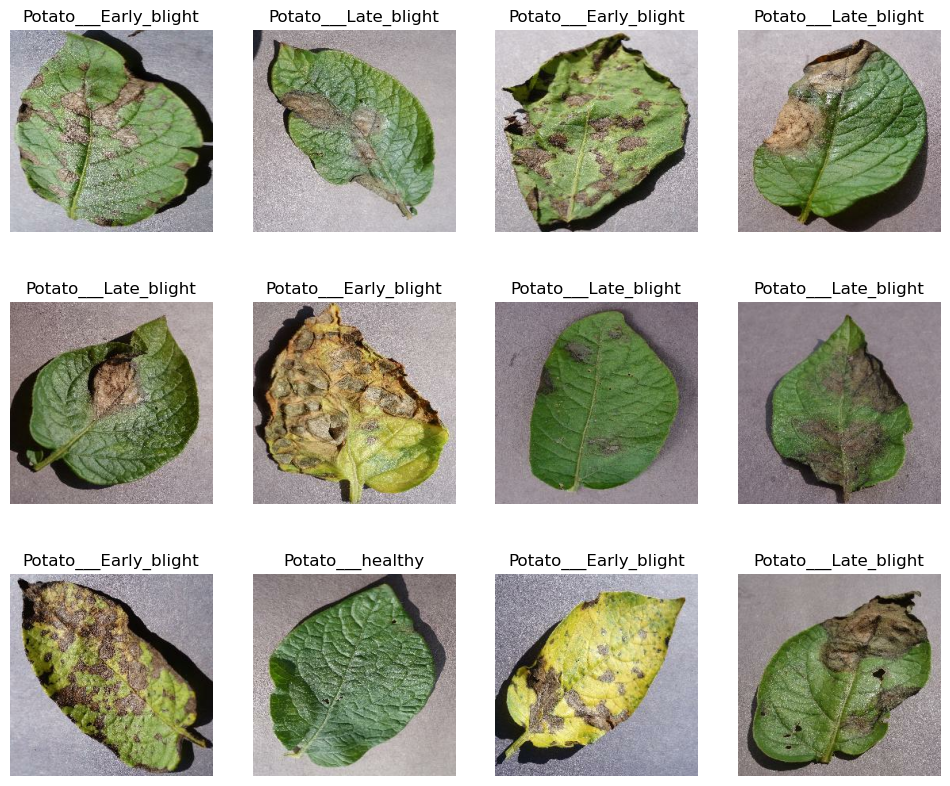

In [49]:
plt.figure(figsize=(12, 10))

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)  # Prints the shape of the image batch
    print(labels_batch.numpy())  # Prints the labels of the batch

    for i in range(12):  # Loop through the first 12 images in the batch
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))  # Display the image
        plt.title(class_names[labels_batch[i].numpy()])  # Use label to fetch class name
        plt.axis('off') 
    plt.show()


## Create a Funcation to Split the Data

In [50]:
def split_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert(train_split+val_split+test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    

    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = split_dataset_tf(dataset)


## Data Normalization

In [51]:
# Data normalization
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

print("Data preparation completed!")


Data preparation completed!


## Data Augmentation

In [52]:
from tensorflow.keras.models import Sequential
# Data Augmentation (applies only to the training dataset)
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Add data augmentation to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Prefetch data for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


## Create a Model Architecture

In [53]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(dataset.class_names), activation='softmax')  # Adjust output layer to match the number of classes
])


# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Change to 'categorical_crossentropy' if using one-hot encoding
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=32
)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 689ms/step - accuracy: 0.4494 - loss: 1.0066 - val_accuracy: 0.6354 - val_loss: 0.9043
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 697ms/step - accuracy: 0.6469 - loss: 0.7391 - val_accuracy: 0.7448 - val_loss: 0.5978
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 732ms/step - accuracy: 0.8038 - loss: 0.4906 - val_accuracy: 0.7344 - val_loss: 0.6044
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 766ms/step - accuracy: 0.8510 - loss: 0.4006 - val_accuracy: 0.9115 - val_loss: 0.3302
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8636 - loss: 0.3689 - val_accuracy: 0.7552 - val_loss: 0.5323
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 792ms/step - accuracy: 0.8555 - loss: 0.3546 - val_accuracy: 0.7240 - val_loss: 0.4669
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 856ms/step - accuracy: 0.8352 - loss: 0.3633 - val_accuracy: 0.9219 - val_loss: 0.2736
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 867ms/step - accuracy: 0.8826 - loss: 0.2744 - val_accuracy: 0.9375 -

## Evaluation the Model

In [54]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.9483 - loss: 0.1879


[0.21540844440460205, 0.9296875]

## Create a Loop To Make a Prediction

This is First Image
Acutal Labels:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Predicted Label:  Potato___Early_blight


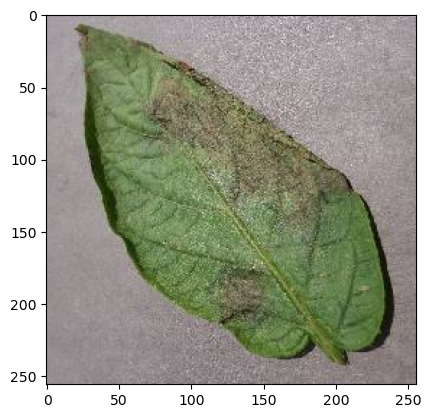

In [72]:
import numpy as np
for image_batch, labels_batch in dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    print('This is First Image')
    plt.imshow(first_image)
    print('Acutal Labels: ',class_names[labels_batch[0].numpy()])

    batch_prediction = model.predict(image_batch)
    print('Predicted Label: ',class_names[np.argmax(batch_prediction[0])])

## Save The Model

In [56]:
model.save('potato_disease.keras')